# Quantum Approximate Optimization Algorithm (QAOA)

## English | [简体中文](./QAOA.ipynb)

<em> Copyright (c) 2020 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

# Preparation

This document provides an interactive experience to show how the quantum approximate optimization algorithm (QAOA) [1] works in the Paddle Quantum. 

To get started, let us import some necessary libraries and functions：

In [1]:
from paddle import fluid

import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

# Background

QAOA is one of quantum algorithms which can be implemented on near-term quantum processors, also called as noisy intermediate-scale quantum (NISQ) processors, and may have wide applications in solving hard computational problems.  For example, it could be applied to tackle a large family of optimization problems, named as the quadratic unconstrained binary optimization (QUBO) which is ubiquitous in the computer science and operation research. Basically, this class can be modeled with the form of

$$F=\max_{z_i\in\{-1,1\}} \sum_{i,j} q_{ij}(1-z_iz_j)=-\min_{z_i\in\{-1,1\}} \sum_{i,j} q_{ij}z_iz_j+ \sum_{i,j} q_{ij} $$


where $z_i$s are binary parameters and coefficients $q_{ij}$ refer to the weight associated to $x_i x_j$. Indeed, it is usually extremely difficult for classical computers to give the exact optimal solution, while QAOA provides an alternative approach which may have a speedup advantage over classical ones to solve these hard problems.

QAOA works as follows: The above optimization problem is first mapped to another problem of finding the ground energy or/and the corresponding ground state for a complex many-body Hamiltonian, e.g., the well-known Ising model or spin-glass model in many-body physics. In this tutorial, we use the Max-Cut problem in graph theory to explain how QAOA works. Essentially, the Max-cut problem is transformed into a problem of finding the smallest eigenvalue and the corresponding eigenvector(s) for a real diagonal matrix $H$. Then, QAOA designates a specific routine with adjustable parameters to approximately find the best solution. Moreover, to accomplish the task, these parameters could be updated via some rules set by fast classical algorithms, such as gradient-free or gradient-based methods. Thus, it is also a quantum-classical hybrid algorithm just as the variational quantum eigensolver (VQE).


# Example

##  1. Max-Cut problem

Given a graph $G$ composed of $N$ nodes and $M$ edges, the problem is to find a cut protocol which divides the node set into two complementary subsets $S$ and $S^\prime$ such that the number of edges between these sets is as large as possible. For example, consider the ring case with four nodes as shown in the figure.

 ![ring4.png](https://release-data.cdn.bcebos.com/PIC%2FMaxCut.png) 
 

Thus, given a cut protocol, if the node $i$ belongs to the set $S$, then it is assigned to $z_i =1$, while $z_j= -1$ for $j \in S^\prime$. Then, for any edge connecting nodes $i$ and $j$, if both nodes are in the same set $S$ or $S^\prime$, then there is $z_iz_j=1$; otherwise, $z_iz_j=-1$. Hence, the cut problem can be formulated as the optimization problem 

$$ F=\min_{z_i\in\{-1, 1\}} z_1 z_2+z_2z_3+z_3z_4+z_4z_1.$$

Here, the weight $q_{ij}s$ are set to $1$ for all edges. Indeed, any feasible solution to the above problem can be described by a bitstring $ \boldsymbol{z}=z_1z_2z_3z_4 \in \{-1, 1\}^4$. Moreover, we need to search over all possible bitstrings of $2^N$ to find its optimal solution, which becomes computionally hard for classical algorithms.

Two methods are provided to pre-process this optimization problem, i.e., to input the given graph with/without weights: 

- Method 1 generates the graph via its full description of nodes and edges,
- Method 2 specifies the graph via its adjacency matrix.



In [2]:
def generate_graph(N, GRAPHMETHOD):
    """
    It plots an N-node graph which is specified by Method 1 or 2.
    
    Args:
        N: number of nodes (vertices) in the graph
        METHOD: choose which method to generate a graph
    Returns:
        the specific graph and its adjacency matrix
    """
    # Method 1 generates a graph by self-definition
    if GRAPHMETHOD == 1:
        print("Method 1 generates the graph from self-definition using EDGE description")
        graph = nx.Graph()
        graph_nodelist=range(N)
        graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
        graph_adjacency = nx.to_numpy_matrix(graph, nodelist=graph_nodelist)
    # Method 2 generates a graph by using its adjacency matrix directly
    elif GRAPHMETHOD == 2:
        print("Method 2 generates the graph from networks using adjacency matrix")
        graph_adjacency = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]])
        graph = nx.Graph(graph_adjacency)
    else:
        print("Method doesn't exist ")

    return graph, graph_adjacency

In this notebook, Method 1 is used to process and then visualize the given graph. Note that the node label starts from $0$ to $ N-1$ in both methods for an $N$-node graph. 

Here, we need to specify:

- number of nodes: $N=4$
- which method to preprocess the graph: GRAPHMETHOD = 1 

Method 1 generates the graph from self-definition using EDGE description
[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


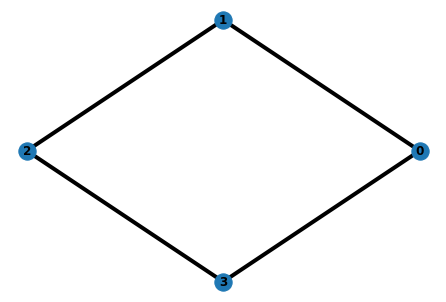

In [3]:
# number of qubits or number of nodes in the graph
N=4  
classical_graph, classical_graph_adjacency= generate_graph(N, GRAPHMETHOD=1)
print(classical_graph_adjacency)

pos = nx.circular_layout(classical_graph)
nx.draw(classical_graph, pos, width=4, with_labels=True, font_weight='bold')
plt.show()

## 2. Encoding

This step encodes the classical optimization problem to its quantum version. Using the transformation $z=1\rightarrow |0\rangle = \begin{bmatrix}1 \\ 0\end{bmatrix}$ and $z=-1\rightarrow |1\rangle = \begin{bmatrix}0 \\ 1\end{bmatrix}$, the binary parameter $z$ is encoded as the eigenvalues of the Pauli-Z operator acting on the single qubit, i.e., $z\rightarrow Z=\begin{bmatrix} 1 & 0\\ 0 & -1\end{bmatrix}$. It yields that the objective function in the classical optimization problem is transformed to the Hamiltonian

$$H_c= Z_1Z_2+Z_2Z_3+Z_3Z_4+Z_4Z_1.$$

Here, for simplicity $Z_iZ_{j}$ stands for the tensor product $Z_i\otimes Z_j$ which represents that Pauli-Z operator acts on each qubit $i, j$ and the identity operation is imposed on the rest. And the Max-Cut problem is mapped to the following quantum optimization problem

$$ F=\min_{|\psi\rangle}\, \langle \psi| H_c |\psi\rangle$$

where the state vector $|\psi\rangle$ describes a $4$-dimensional complex vector which is normalized to $1$, and $\langle \psi|$ is its conjugate transpose form. It is equivalent to find the smallest eigenvalue $F$ and the corresponding eigenstate(s) for the matrix $H_c$.

In [4]:
def H_generator(N, adjacency_matrix):
    """
    This function maps the given graph via its adjacency matrix to the corresponding Hamiltiona H_c.
    
    Args:
        N: number of qubits, or number of nodes in the graph, or number of parameters in the classical problem
        adjacency_matrix:  the adjacency matrix generated from the graph encoding the classical problem
    Returns:
        the problem-based Hmiltonian H's list form generated from the graph_adjacency matrix for the given graph
    """
    H_list = []
    # Generate the Hamiltonian H_c from the graph via its adjacency matrix
    for row in range(N):
        for col in range(N):
            if adjacency_matrix[row, col] and row < col:
                # Construct the Hamiltonian in the list form for the calculation of expectation value
                H_list.append([1.0, 'z'+str(row) + ',z' + str(col)])

    return H_list

The explicit form of the matrix $H_c$, including its maximal and minimal eigenvalues, can be imported, which later could be used to benchmark the performance of QAOA. 

In [5]:
# Convert the Hamiltonian's list form to matrix form
H_matrix = pauli_str_to_matrix(H_generator(N, classical_graph_adjacency), N)

H_diag = np.diag(H_matrix).real
H_max = np.max(H_diag)
H_min = np.min(H_diag)

print(H_diag)
print('H_max:', H_max, '  H_min:', H_min)

[ 4.  0.  0.  0.  0. -4.  0.  0.  0.  0. -4.  0.  0.  0.  0.  4.]
H_max: 4.0   H_min: -4.0


## 3. Building

This part is to build up the parameterized quantum circuit of QAOA to perform the computation process. Particularly, the QAOA circuit is constructed by alternatively placing two parameterized modules

$$U_x(\beta_P)U_c(\gamma_P)\dots U_x(\beta_1)U_c(\gamma_1)$$

where $P$ is the number of layers to place these two modules. Particularly, one is governed by the encoding matrix $H_c$ via the unitary transformation

$$U_c(\gamma)=e^{-i \gamma H_c }$$

where $i$ is the imaginary unit, and $\gamma\in [0, \pi]$ is to be optimized. The other one is 

$$U_x(\beta)=e^{-i \beta H_x },$$

where $\beta\in [0, \pi]$ and the driving Hamiltonian or matrix $H_x$ adimits an explicit form of

$$H_x =X_1+X_2+X_3+X_4 $$

where the operator $X=\begin{bmatrix} 0 & 1\\ 1& 0\end{bmatrix}$ defines the Pauli-X operation acting on the qubit.



Further, each module in the QAOA circuit can be decomposed into a series of operations acting on single qubits and two qubits. In particular, the first has the decomposition of $U_c(\gamma)=\prod_{(i, j)}e^{-i \gamma Z_i\otimes Z_j }$ while there is $U_x(\beta)=\prod_{i}e^{-i \beta X_i}$ for the second. This is illustrated in the following figure.

 <!--
![Circ](https://release-data.cdn.bcebos.com/PIC%2FQAOACir.png) 
-->
<img src="./figures/QAOAcircuit.png" width="600" >

Then, based on

- initial state of QAOA circuits 
- adjacency matrix describing the graph
- number of qubits
- number of layers

we are able to construct the standard QAOA circuit:

In [6]:
def circuit_QAOA(theta, adjacency_matrix, N, P):
    """
    This function constructs the parameterized QAOA circuit which is composed of P layers of two blocks:
    one block is based on the problem Hamiltonian H which encodes the classical problem,
    and the other is constructed from the driving Hamiltonian describing the rotation around Pauli X
    acting on each qubit. It outputs the final state of the QAOA circuit.
    
    Args:
        theta: parameters to be optimized in the QAOA circuit
        adjacency_matrix:  the adjacency matrix of the graph encoding the classical problem
        N: number of qubits, or equivalently, the number of parameters in the original classical problem
        P: number of layers of two blocks in the QAOA circuit
    Returns:
        the QAOA circuit
    """

    cir = UAnsatz(N)
    
    #prepare the input state in the uniform superposition of 2^N bit-strings in the computational basis
    cir.superposition_layer()
    # This loop defines the QAOA circuit with P layers of two blocks
    for layer in range(P):
        # The second and third loops construct the first block which involves two-qubit operation
        #  e^{-i\gamma Z_iZ_j} acting on a pair of qubits or nodes i and j in the circuit in each layer.
        for row in range(N):
            for col in range(N):
                if adjacency_matrix[row, col] and row < col:
                    cir.cnot([row, col])
                    cir.rz(theta[layer][0], col)
                    cir.cnot([row, col])
        # This loop constructs the second block only involving the single-qubit operation e^{-i\beta X}.
        for i in range(N):
            cir.rx(theta[layer][1], i)

    return cir

Indeed, the QAOA circuit could be extended to other structures by replacing the modules in the above standard circuit to improve QAOA performance. Here, we provide one candidate extension in which the Pauli-X rotation $R_x(\beta) $ on each qubit in the driving matrix $H_x$ is replaced by an arbitrary rotation described by $U3(\beta_1,\beta_2,\beta_3)$. 

In [7]:
def circuit_extend_QAOA(theta, adjacency_matrix, N, P):
    """
    This is an extended version of the QAOA circuit, and the main difference is the block constructed
    from the driving Hamiltonian describing the rotation around an arbitrary direction on each qubit.

    Args:
        theta: parameters to be optimized in the QAOA circuit
        input_state: input state of the QAOA circuit which usually is the uniform superposition of 2^N bit-strings
                     in the computational basis
        adjacency_matrix:  the adjacency matrix of the problem graph encoding the original problem
        N: number of qubits, or equivalently, the number of parameters in the original classical problem
        P: number of layers of two blocks in the QAOA circuit
    Returns:
        the extended QAOA circuit

    Note:
        If this circuit_extend_QAOA function is used to construct QAOA circuit, then we need to change the parameter layer
        in the Net function defined below from the Net(shape=[D, 2]) for circuit_QAOA function to Net(shape=[D, 4])
        because the number of parameters doubles in each layer in this QAOA circuit.
    """
    cir = UAnsatz(N)

    #prepare the input state in the uniform superposition of 2^N bit-strings in the computational basis
    cir.superposition_layer()
    for layer in range(P):
        for row in range(N):
            for col in range(N):
                if adjacency_matrix[row, col] and row < col:
                    cir.cnot([row, col])
                    cir.rz(theta[layer][0], col)
                    cir.cnot([row, col])

        for i in range(N):
            cir.u3(*theta[layer][1:], i)

    return cir

Finally, the QAOA circuit outputs

$$|\psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)\rangle=U_x(\beta_P)U_c(\gamma_P)\dots U_x(\beta_1)U_c(\gamma_1)|+\rangle_1\dots|+\rangle_N$$

where each qubit is initialized as the superposition state $|+\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$. And we are able to obtain the loss function for the QAOA circuit

$$F_P=\min_{\boldsymbol{\beta},\boldsymbol{\gamma}} \langle \psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)| H_c|\psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)\rangle.$$

Additionally, we may tend to fast classical algorithms to update the parameter vectors $\boldsymbol{\beta},\boldsymbol{\gamma}$ to achieve the optimal value for the above quantum optimization problem. 

In Paddle Quantum, this process is accomplished in the Net function:

In [8]:
class Net(fluid.dygraph.Layer):
    """
    It constructs the net for QAOA which combines the  QAOA circuit with the classical optimizer which sets rules
    to update parameters described by theta introduced in the QAOA circuit.

    """
    def __init__(
        self,
        shape,
        param_attr=fluid.initializer.Uniform(low=0.0, high=np.pi, seed=1024),
        dtype="float64",
    ):
        super(Net, self).__init__()

        self.theta = self.create_parameter(
            shape=shape, attr=param_attr, dtype=dtype, is_bias=False
        )

    def forward(self, adjacency_matrix, N, P, METHOD):
        """
        This function constructs the loss function for the QAOA circuit.

        Args:
            adjacency_matrix: the adjacency matrix generated from the graph encoding the classical problem
            N: number of qubits
            P: number of layers
            METHOD: which version of QAOA is chosen to solve the problem, i.e., standard version labeled by 1 or
            extended version by 2.
        Returns:
            the loss function for the parameterized QAOA circuit and the circuit itself
        """
        
        # Generate the problem_based quantum Hamiltonian H_problem based on the classical problem in paddle
        H_problem = H_generator(N, adjacency_matrix)

        # The standard QAOA circuit: the function circuit_QAOA is used to construct the circuit, indexed by METHOD 1.
        if METHOD == 1:
            cir = circuit_QAOA(self.theta, adjacency_matrix, N, P)
        # The extended QAOA circuit: the function circuit_extend_QAOA is used to construct the net, indexed by METHOD 2.
        elif METHOD == 2:
            cir = circuit_extend_QAOA(self.theta, adjacency_matrix, N, P)
        else:
            raise ValueError("Wrong method called!")

        cir.run_state_vector()
        loss = cir.expecval(H_problem)

        return loss, cir

## 4. Training

In this part, the QAOA circuit is trained to find the "optimal" solution to the optimization problem.

First, let us specify some parameters:

- number of qubits: N
- number of layes: P
- iteration steps: ITR
- learning rate: LR

In [9]:
N = 4 # number of qubits, or number of nodes in the graph
P = 4 # number of layers 
ITR = 120  # number of iteration steps
LR = 0.1  # learning rate

Then, with the following inputs

- initial state: each qubit is initialized as $\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$ by calling `cir.superposition_layer()`
- Standard QAOA circuit (METHOD = 1) or Extended QAOA (METHOD = 2) 
- Classical optimizer: Adam optimizer

we are able to train the whole net：

In [10]:
def Paddle_QAOA(classical_graph_adjacency, N, P, METHOD, ITR, LR):
    """
    This is the core function to run QAOA.

     Args:
         classical_graph_adjacency: adjacency matrix to describe the graph which encodes the classical problem
         N: number of qubits (default value N=4)
         P: number of layers of blocks in the QAOA circuit (default value P=4)
         METHOD: which version of the QAOA circuit is used: 1, standard circuit (default); 2, extended circuit
         ITR: number of iteration steps for QAOA (default value ITR=120)
         LR: learning rate for the gradient-based optimization method (default value LR=0.1)
     Returns:
         the optimized QAOA circuit
    """
    with fluid.dygraph.guard():
        # Construct the net or QAOA circuits based on the standard modules
        if METHOD == 1:
            net = Net(shape=[P, 2])
        # Construct the net or QAOA circuits based on the extended modules
        elif METHOD == 2:
            net = Net(shape=[P, 4])
        else:
            raise ValueError("Wrong method called!")

        # Classical optimizer
        opt = fluid.optimizer.AdamOptimizer(learning_rate=LR, parameter_list=net.parameters())

        # Gradient descent loop
        summary_iter, summary_loss = [], []
        for itr in range(1, ITR + 1):
            loss, cir = net(
                classical_graph_adjacency, N, P, METHOD
            )
            loss.backward()
            opt.minimize(loss)
            net.clear_gradients()

            if itr % 10 == 0:
                print("iter:", itr, "  loss:", "%.4f" % loss.numpy())
            summary_loss.append(loss[0][0].numpy())
            summary_iter.append(itr)

        theta_opt = net.parameters()[0].numpy()
        print("Optmized parameters theta:\n", theta_opt)
        
        os.makedirs("output", exist_ok=True)
        np.savez("./output/summary_data", iter=summary_iter, energy=summary_loss)

    return cir

After the completion of training, the QAOA outputs the results, including the optimal parameters $\boldsymbol{\beta}^*$ and $\boldsymbol{\gamma}^*$. By contrast, its performance can be evaluated with the true value of the optimization problem.

Method 1 generates the graph from self-definition using EDGE description
iter: 10   loss: -3.8531
iter: 20   loss: -3.9626
iter: 30   loss: -3.9845
iter: 40   loss: -3.9944
iter: 50   loss: -3.9984
iter: 60   loss: -3.9996
iter: 70   loss: -3.9999
iter: 80   loss: -4.0000
iter: 90   loss: -4.0000
iter: 100   loss: -4.0000
iter: 110   loss: -4.0000
iter: 120   loss: -4.0000
Optmized parameters theta:
 [[0.24726127 0.53087308]
 [0.94954664 1.9974811 ]
 [1.14545257 2.27267827]
 [2.98845718 2.84445401]]


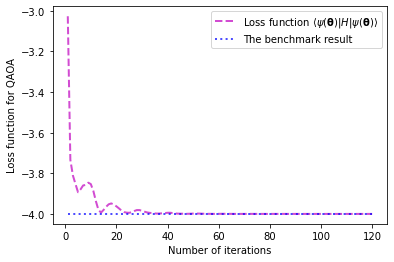

In [11]:
classical_graph, classical_graph_adjacency = generate_graph(N, 1)

opt_cir = Paddle_QAOA(classical_graph_adjacency, N =4, P=4, METHOD=1, ITR=120, LR=0.1)

# Load the data of QAOA
x1 = np.load('./output/summary_data.npz')

H_min = np.ones([len(x1['iter'])]) * H_min

# Plot loss
loss_QAOA, = plt.plot(x1['iter'], x1['energy'], \
                                        alpha=0.7, marker='', linestyle="--", linewidth=2, color='m')
benchmark, = plt.plot(x1['iter'], H_min, alpha=0.7, marker='', linestyle=":", linewidth=2, color='b')
plt.xlabel('Number of iterations')
plt.ylabel('Loss function for QAOA')

plt.legend(handles=[
    loss_QAOA,
    benchmark
],
    labels=[
            r'Loss function $\left\langle {\psi \left( {\bf{\theta }} \right)} '
            r'\right|H\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle $',
            'The benchmark result',
    ], loc='best')

# Show the plot
plt.show()


## 5. Decoding 

However, the output of optimized QAOA circuits 

$$|\psi(\boldsymbol{\beta}^*,\boldsymbol{\gamma}^*, P)\rangle=\sum_{i=1}^{2^4}\lambda_i |\boldsymbol{x}_i\rangle$$

does not give us the answer to the Max-Cut problem directly. Instead, each bitstring $\boldsymbol{x}_i=x_1x_2x_3 x_4\in \{0, 1\}^4$ in the state $|\psi(\boldsymbol{\beta}^*,\boldsymbol{\gamma}^*, P)\rangle$ represents a possible classical solution. Thus, we need to decode the ouptut of QAOA circuits. 

The task of decoding quantum answer can be accomplished via measurement. Given the output state, the measurement statistics for each bitstring obeys the probability distribution

$$ p(\boldsymbol{x})=|\langle \boldsymbol{x}|\psi(\boldsymbol{\beta}^*,\boldsymbol{\gamma}^*,P)\rangle|^2.$$
              
And this distribution is plotted using the following function:

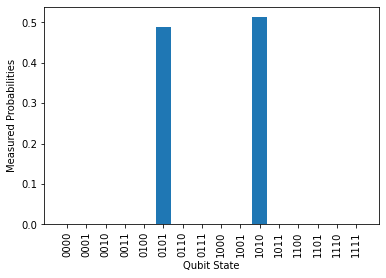

In [12]:
with fluid.dygraph.guard():
    # Measure the output state of the QAOA circuit for 1024 shots by default
    prob_measure = opt_cir.measure(plot=True)

Again, using the relation $|x \rangle\rightarrow z=2x-1$, we are able to obtain a classical answer from the quantum state. Specifically, assume that $z_i=-1$ for $i \in S$ and $z_j=-1$ for $j \in S^\prime$. Thus, one bistring sampled from the output state of QAOA corresponds to one feasible cut to the given graph. And it is highly possible that the higher probability the bitstring is, the more likely it gives rise to the max cut protocol.

The bistring with the largest probability is picked up, and then mapped back to solution to the Max-Cut problem ：

- the node set $S$ is in blue color
- the node set $S^\prime$ is in red color
- the dashed lines represent the cut edges 

The output bitstring: ['1010']


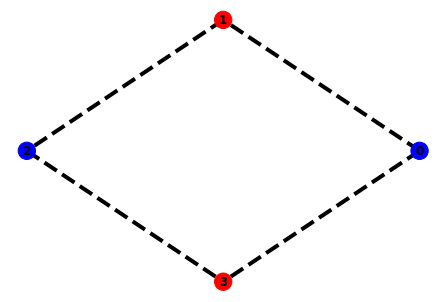

In [13]:
# Find the max value in measured probability of bitstrings
max_prob = max(prob_measure.values())
# Find the bitstring with max probability
solution_list = [result[0] for result in prob_measure.items() if result[1] == max_prob]
print("The output bitstring:", solution_list)

# Draw the graph representing the first bitstring in the solution_list to the MaxCut-like problem
head_bitstring = solution_list[0]

node_cut = ["blue" if head_bitstring[node] == "1" else "red" for node in classical_graph]

edge_cut = [
    "solid" if head_bitstring[node_row] == head_bitstring[node_col] else "dashed"
    for node_row, node_col in classical_graph.edges()
    ]
nx.draw(
        classical_graph,
        pos,
        node_color=node_cut,
        style=edge_cut,
        width=4,
        with_labels=True,
        font_weight="bold",
)
plt.show()

# References

[1] [Farhi, E., Goldstone, J. & Gutmann, S. A Quantum Approximate Optimization Algorithm. arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)